<a href="https://colab.research.google.com/github/LSSTDESC/bayesian-pipelines-cosmology/blob/u%2FEiffL%2Finfrastructure/notebooks/forward_model/LensingForwardModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installing package
!pip install --quiet --user git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git git+https://github.com/LSSTDESC/bayesian-pipelines-cosmology.git@u/EiffL/infrastructure
# Downloading useful data
!wget --quiet https://github.com/LSSTDESC/star-challenge/raw/main/cosmodc2-srd-sample/generation/shear_photoz_stack.hdf5
!wget --quiet https://github.com/DifferentiableUniverseInitiative/jaxpm-paper/raw/main/notebooks/camels_25_64_pkloss.params

In [108]:
%pylab inline
import h5py
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from jax_cosmo.scipy.integrate import simps
import astropy.units as u

from bpcosmo.pm import get_density_planes
from jaxpm.lensing import convergence_Born

import numpyro
import numpyro.distributions as dist

Populating the interactive namespace from numpy and matplotlib


### Loading DC2 parameters

For now, just n(z), but we could also load masks and such

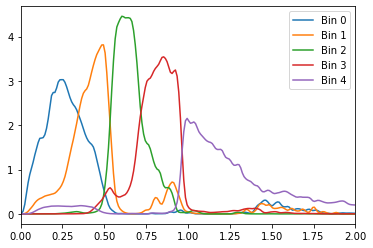

In [2]:
# Reading the DC2 tomographic bins into redshift distribution objects
with h5py.File("shear_photoz_stack.hdf5") as f:
    group = f["n_of_z"]
    # Read the z grid
    source = group["source"]
    z_shear = source['z'][::]
    # Read the true n(z)
    nz_shear = [jc.redshift.kde_nz(z_shear,  
                                   source[f"bin_{i}"][:], 
                                   bw=0.01, zmax=2.5) for i in range(5)] 
for i in range(5):
  plot(z_shear, nz_shear[i](z_shear), color='C%d'%i, label="Bin %d"%i)
legend()
xlim(0,2);

In [3]:
# Loads some correction factors to improve the resolution of the simulation
import pickle
params = pickle.load(open( "camels_25_64_pkloss.params", "rb" ) )

/Users/eleni/.local/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/Users/eleni/.local/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


### Definition of the forward model

In [4]:
import pdf_maxent as pme
from scipy.interpolate import interp1d

In [22]:
# Reconstruct PDFs from a given number moments

x, sol0 = pme.reconstruct_from_moments(nz_shear[0](z_shear), z_shear, 9)
x, sol1 = pme.reconstruct_from_moments(nz_shear[1](z_shear), z_shear, 9)
x, sol2 = pme.reconstruct_from_moments(nz_shear[2](z_shear), z_shear, 6)
x, sol3 = pme.reconstruct_from_moments(nz_shear[3](z_shear), z_shear, 5)
x, sol4 = pme.reconstruct_from_moments(nz_shear[4](z_shear), z_shear, 8)

sol0 = interp1d(x, sol0, fill_value="extrapolate")
sol1 = interp1d(x, sol1, fill_value="extrapolate")
sol2 = interp1d(x, sol2, fill_value="extrapolate")
sol3 = interp1d(x, sol3, fill_value="extrapolate")
sol4 = interp1d(x, sol4, fill_value="extrapolate")

In [25]:
# Merge into a format readable by the forward model
# The reconstructed PDFs need to be functions of redshifts.
# For the time being, we will use scipy interp1d.

nzs_s_sys = [sol0, sol1, sol2, sol3, sol4]

In [118]:
def forward_model(box_size=[400., 400., 4000.], # In Mpc/h
                  nc = [64, 64, 640],         # Number of pixels
                  field_size = 20,            # Size of the lensing field in degrees
                  field_npix = 128,           # Number of pixels in the lensing field
                  sigma_e = 0.25,             # Standard deviation of galaxy ellipticities
                  galaxy_density = 10.,       # Galaxy density per arcmin^2, per redshift bin
                  nzs_s_sys = nzs_s_sys):
    """This function defines the top-level forward model for our observations"""
    # Sampling cosmological parameters and defines cosmology
    Omega_c = numpyro.sample('Omega_c', dist.Uniform(0.1, 0.9))
    sigma8 = numpyro.sample('sigma8', dist.Uniform(0.4, 1.0))
    Omega_b = numpyro.sample('Omega_b', dist.Uniform(0.03, 0.07))
    h = numpyro.sample('h', dist.Uniform(0.55, 0.91))
    n_s = numpyro.sample('n_s', dist.Uniform(0.87, 1.07)) 
    w0 = numpyro.sample('w0', dist.Uniform(-2.0, -0.33))
    cosmo = jc.Cosmology(Omega_c=Omega_c, sigma8=sigma8, Omega_b=Omega_b,
                        h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)
    # Generate lightcone density planes through an nbody
    density_planes = get_density_planes(cosmo, box_size=box_size, nc=nc, neural_spline_params=params)
    
    #Create photoz systematics parameters, and create derived nz 
    #nzs_s_sys = [jc.redshift.systematic_shift(nzi, 
    #                                        numpyro.sample('dz%d'%i, dist.Normal(0., 0.01)), 
    #                                        zmax=2.5) 
    #            for i, nzi in enumerate(nz_shear)]
    
    # Defining the coordinate grid for lensing map
    xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                             np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates
    coords = jnp.array((np.stack([xgrid, ygrid], axis=0)*u.deg).to(u.rad))
    
    # Generate convergence maps by integrating over nz and source planes
    convergence_maps = [simps(lambda z: nz(z).reshape([-1,1,1]) * 
                              convergence_Born(cosmo, density_planes, coords, z), 0., 2.5, N=64)
                      for nz in nzs_s_sys]

    # Apply noise to the maps (this defines the likelihood)
    observed_maps = [numpyro.sample('kappa_%d'%i, 
                                  dist.Normal(k, sigma_e/jnp.sqrt(10**2*galaxy_density))) # assumes pixel size of 10 arcmin
                   for i,k in enumerate(convergence_maps)]

    return observed_maps

Once the model is defined, it needs to be seeded, and then can be ran and traced if one wants to access all the stochastic variables.

In [ ]:
# Fixes the random seed for the model
seeded_model = numpyro.handlers.seed(forward_model, jax.random.PRNGKey(0))

# It can then be used directly as a function
observations = seeded_model()

# Or can be fully traces 
trace = numpyro.handlers.trace(seeded_model).get_trace()

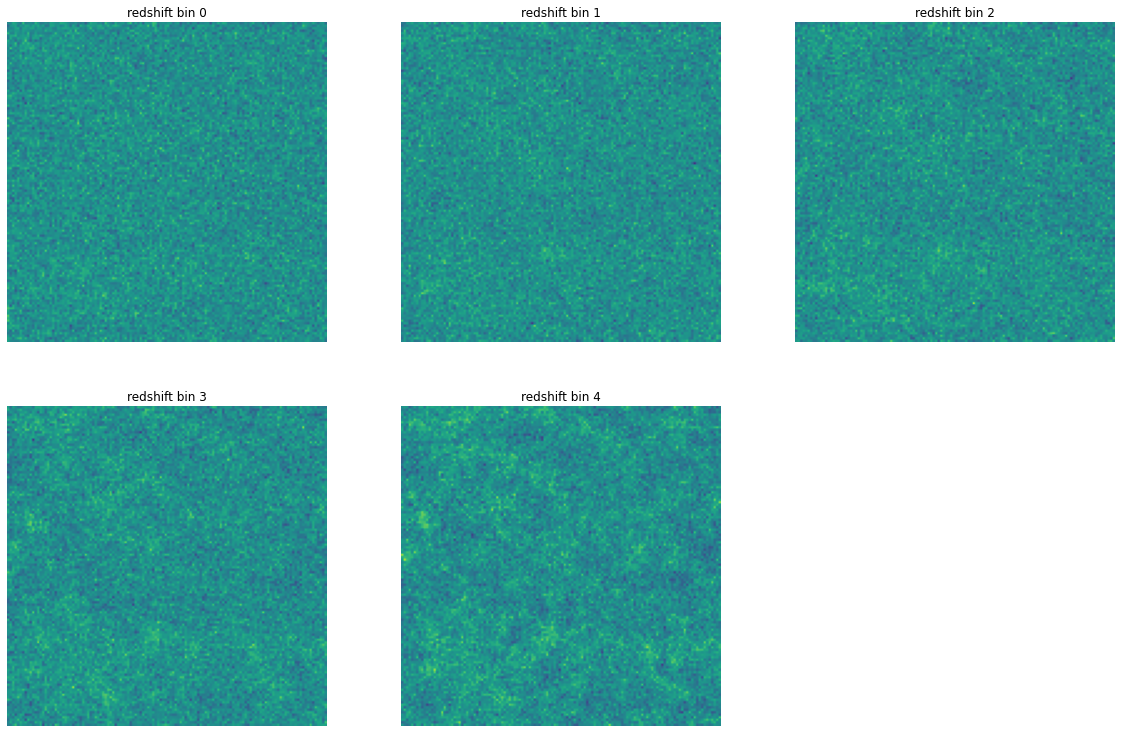

In [99]:
figure(figsize=[20,20])
for i in range(5):
    subplot(3,3,i+1)
    title('redshift bin %d'%i)
    imshow(observations[i],vmax=0.05,vmin=-0.05)
    axis('off')

Let's have a look at the simulated fields

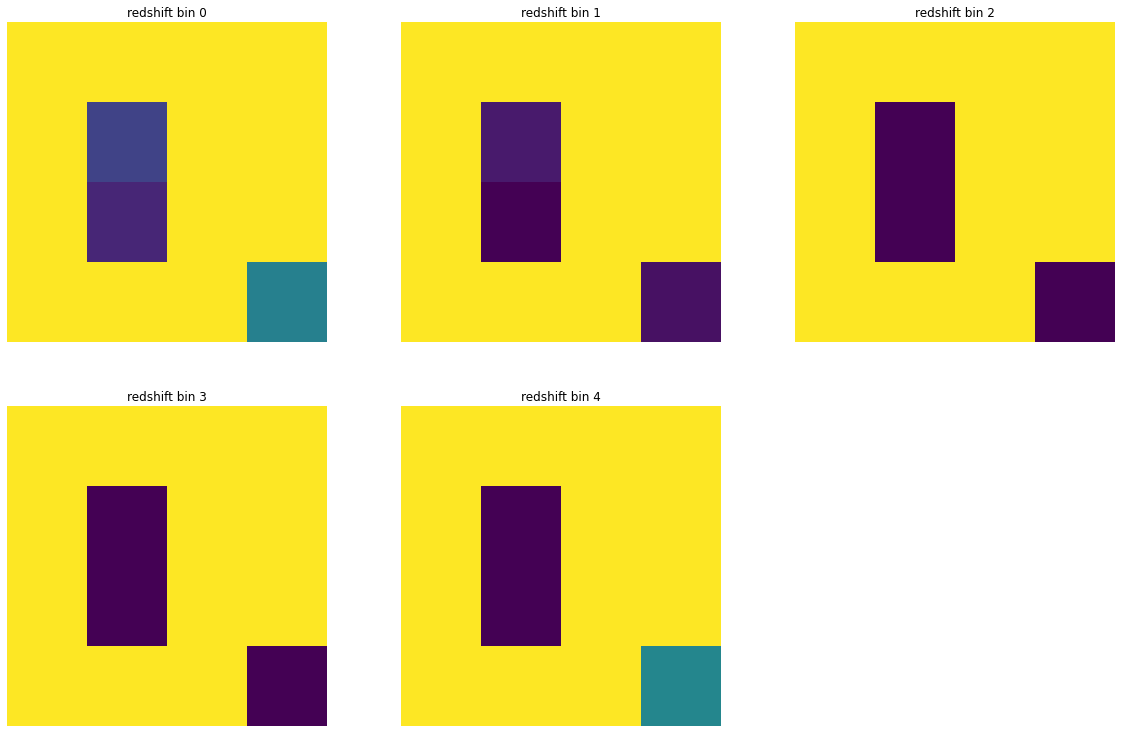

In [119]:
figure(figsize=[20,20])
for i in range(5):
    subplot(3,3,i+1)
    title('redshift bin %d'%i)
    imshow(trace['kappa_%d'%i]['value'],vmax=0.05,vmin=-0.05)
    axis('off')

But if we want we can also retrieve from the trace the underlying convergence field

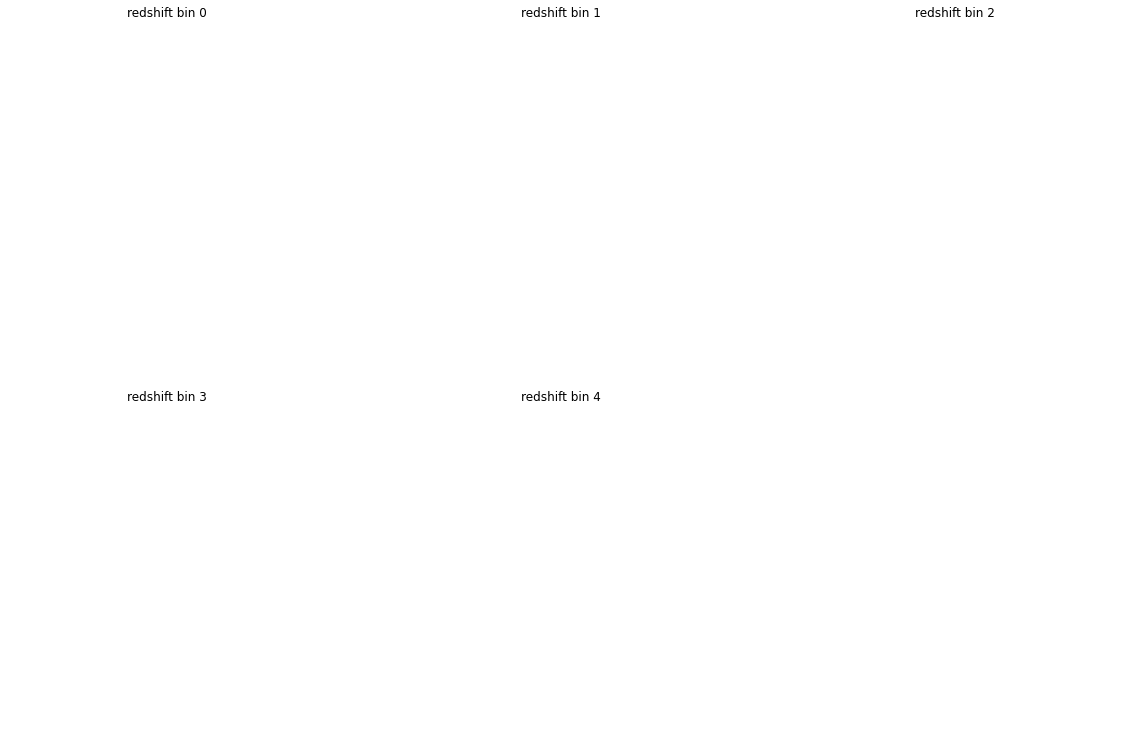

In [101]:
figure(figsize=[20,20])
for i in range(5):
    subplot(3,3,i+1)
    title('redshift bin %d'%i)
    imshow(trace['kappa_%d'%i]['fn'].mean)
    axis('off')

In [12]:
from lenstools import ConvergenceMap
l_edges_kmap = np.logspace(1.7,3,20)
for i in range(5):
  map = ConvergenceMap(trace['kappa_%d'%i]['value'], angle=20*u.deg)
  l_k,Pl_k = map.powerSpectrum(l_edges_kmap)
  loglog(l_k, l_k*(l_k+1)/(2*pi)*Pl_k, color='C%d'%i)

  map = ConvergenceMap(trace['kappa_%d'%i]['fn'].mean, angle=20*u.deg)
  l_k,Pl_k = map.powerSpectrum(l_edges_kmap)
  loglog(l_k, l_k*(l_k+1)/(2*pi)*Pl_k, '--', color='C%d'%i)

xlabel(r'$\ell$');
ylabel(r'$\ell (\ell +1 )/2\pi C_\ell$');

ImportError: cannot import name 'MPIPool' from 'emcee.utils' (/Users/eleni/opt/anaconda3/lib/python3.8/site-packages/emcee/utils.py)